In [122]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque
import numpy as np

#Hyperparameters
learning_rate = 5e-4
gamma         = 1
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

losses = []
class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        
        self.fc1   = nn.Linear(4,64)
        self.fc_pi = nn.Linear(64,2)
        self.fc_v  = nn.Linear(64,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
            
        s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                          torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                          torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a
        
    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        for i in range(K_epoch):
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a)) 

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            loss = -torch.min(surr1,surr2) + F.smooth_l1_loss(self.v(s) , td_target.detach())
            losses.append(loss.mean().item())
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        

scores_deque = deque(maxlen=100) 
scores_mean = []
env = gym.make('CartPole-v1')
model = PPO()

for n_epi in range(500):
    s = env.reset()
    done = False
    score = 0
    while not done:
        for t in range(T_horizon):
            prob = model.pi(torch.from_numpy(s).float())
            m = Categorical(prob)
            a = m.sample().item()
            s_prime, r, done, info = env.step(a)
            score+=r

            model.put_data((s, a, r, s_prime, prob[a].item(), done))
            s = s_prime

            if done:
                break

        model.train_net()
    scores_deque.append(score)
    scores_mean.append(np.mean(scores_deque))

    if n_epi%100==0 and n_epi!=0:
        print(f'Episode {n_epi}: mean average score at {scores_mean[-1]}')
    if scores_mean[-1] > 150: 
        print(f'Solved at {n_epi} {scores_mean[-1]}')
        break

env.close()


Episode 100: mean average score at 22.31
Episode 200: mean average score at 48.96
Episode 300: mean average score at 98.71
Solved at 352 150.76


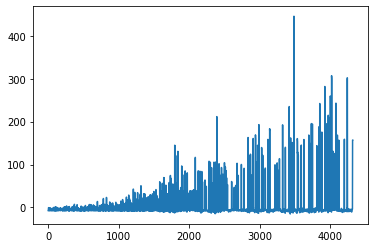

In [123]:
plt.plot(losses)

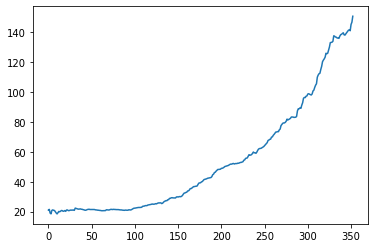

In [124]:
plt.plot(scores_mean)